# 📊 Objective 2: Fan Vote Leverage Analysis
## MCM Problem C 2026

**Core Question:** Which voting method gives fans more POWER?

### Fan Vote Leverage Index (FVLI)

We define FVLI as the sensitivity of survival probability to fan vote changes:

$$\text{FVLI} = \frac{\partial P(\text{survive})}{\partial F_i}$$

### What This Notebook Covers:
1. [Mathematical Derivation of FVLI](#1-math)
2. [Empirical FVLI Computation](#2-empirical)
3. [Method Comparison](#3-comparison)
4. [Fan Vote "Break-Even" Analysis](#4-breakeven)

---

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import rankdata
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

DATA_PATH = Path('../../data')
OUTPUT_PATH = DATA_PATH / 'obj2'

# Load data
fan_votes_df = pd.read_csv(DATA_PATH / 'obj1' / 'fan_vote_estimates.csv')
counterfactual_df = pd.read_csv(OUTPUT_PATH / 'counterfactual_history_with_uncertainty.csv')

print(f"✓ Loaded {len(fan_votes_df)} fan vote estimates")

✓ Loaded 2067 fan vote estimates


---

## 2. Mathematical Derivation of FVLI <a id='1-math'></a>

### Percent-Based Method

Combined score: $S_i = \frac{J_i}{\sum J} + \frac{F_i}{\sum F}$

Taking derivative w.r.t. $F_i$:

$$\frac{\partial S_i}{\partial F_i} = \frac{1}{\sum F} - \frac{F_i}{(\sum F)^2} = \frac{1}{\sum F}\left(1 - \frac{F_i}{\sum F}\right)$$

**Interpretation:** 
- FVLI decreases as contestant's fan vote share increases
- Maximum leverage when contestant has very few votes

### Rank-Based Method

Ranking is discontinuous, so we use a **probabilistic definition**:

$$\text{FVLI}_{rank} \approx P(\text{rank improves by 1} | \Delta F = \epsilon)$$

This depends on the vote gaps between contestants.

In [2]:
def compute_fvli_percent(judge_scores, fan_votes, contestant_idx):
    """
    Compute analytical FVLI for percent method.
    
    FVLI = (1/total_votes) * (1 - fan_share)
    """
    total_votes = np.sum(fan_votes)
    fan_share = fan_votes[contestant_idx] / total_votes
    
    fvli = (1 / total_votes) * (1 - fan_share)
    
    return fvli


def compute_fvli_rank_empirical(judge_scores, fan_votes, contestant_idx, n_samples=100):
    """
    Compute empirical FVLI for rank method via Monte Carlo.
    
    Measures: How much does a small fan vote increase improve ranking?
    """
    judge_scores = np.array(judge_scores)
    fan_votes = np.array(fan_votes)
    n = len(fan_votes)
    
    # Current rank
    fan_ranks_orig = rankdata(-fan_votes, method='average')
    orig_rank = fan_ranks_orig[contestant_idx]
    
    # Compute sensitivity: how much vote increase needed to improve rank?
    improvements = []
    
    for eps_pct in [0.01, 0.05, 0.10, 0.15, 0.20]:  # 1-20% increase
        new_votes = fan_votes.copy()
        new_votes[contestant_idx] *= (1 + eps_pct)
        
        fan_ranks_new = rankdata(-new_votes, method='average')
        new_rank = fan_ranks_new[contestant_idx]
        
        rank_improvement = orig_rank - new_rank
        improvements.append(rank_improvement / eps_pct)  # Normalize by epsilon
    
    # FVLI = average rank improvement per unit vote increase
    fvli = np.mean(improvements)
    
    return fvli


def compute_fvli_survival_sensitivity(judge_scores, fan_votes, contestant_idx, method='percent', n_samples=500):
    """
    Compute FVLI as survival probability sensitivity.
    
    FVLI = d(P(survive)) / d(fan_vote_share)
    
    Uses Monte Carlo to estimate probability change.
    """
    judge_scores = np.array(judge_scores)
    fan_votes = np.array(fan_votes)
    n = len(fan_votes)
    
    # Add small noise and check survival
    survival_at_levels = {}
    
    for boost_pct in [-0.2, -0.1, 0, 0.1, 0.2, 0.3]:
        survive_count = 0
        
        for _ in range(n_samples):
            # Add noise to all votes
            noisy_votes = fan_votes * (1 + np.random.normal(0, 0.1, n))
            # Boost target contestant
            noisy_votes[contestant_idx] *= (1 + boost_pct)
            noisy_votes = np.maximum(noisy_votes, 1)
            
            # Check elimination
            if method == 'percent':
                judge_pct = judge_scores / judge_scores.sum()
                fan_pct = noisy_votes / noisy_votes.sum()
                combined = judge_pct + fan_pct
                eliminated_idx = np.argmin(combined)
            else:  # rank
                judge_ranks = rankdata(-judge_scores, method='average')
                fan_ranks = rankdata(-noisy_votes, method='average')
                combined = judge_ranks + fan_ranks
                eliminated_idx = np.argmax(combined)
            
            if eliminated_idx != contestant_idx:
                survive_count += 1
        
        survival_at_levels[boost_pct] = survive_count / n_samples
    
    # Compute FVLI as slope of survival probability curve
    x = list(survival_at_levels.keys())
    y = list(survival_at_levels.values())
    
    # Linear regression slope
    fvli = np.polyfit(x, y, 1)[0]
    
    return fvli, survival_at_levels


print("✓ FVLI functions defined")

✓ FVLI functions defined


---

## 3. Empirical FVLI Computation <a id='2-empirical'></a>

Compute FVLI for all contestant-weeks and compare methods.

In [3]:
# Compute FVLI for each contestant-week
print("Computing FVLI for all contestant-weeks...")

fvli_results = []
grouped = fan_votes_df.groupby(['season', 'week'])

for (season, week), week_df in tqdm(grouped, desc="Computing FVLI"):
    if len(week_df) < 3:  # Need at least 3 contestants
        continue
    
    judge_scores = week_df['judge_score'].values
    fan_votes = week_df['fan_votes_estimate'].values
    contestants = week_df['celebrity_name'].values
    eliminated = week_df['was_eliminated'].values
    
    for i, name in enumerate(contestants):
        # Analytical FVLI for percent method
        fvli_pct_analytical = compute_fvli_percent(judge_scores, fan_votes, i)
        
        # Empirical FVLI for rank method
        fvli_rank = compute_fvli_rank_empirical(judge_scores, fan_votes, i)
        
        fvli_results.append({
            'season': season,
            'week': week,
            'celebrity_name': name,
            'judge_score': judge_scores[i],
            'fan_votes': fan_votes[i],
            'fan_share': fan_votes[i] / fan_votes.sum(),
            'was_eliminated': eliminated[i],
            'fvli_percent': fvli_pct_analytical,
            'fvli_rank': fvli_rank,
            'n_contestants': len(contestants)
        })

fvli_df = pd.DataFrame(fvli_results)
print(f"\n✓ Computed FVLI for {len(fvli_df)} contestant-weeks")

Computing FVLI for all contestant-weeks...


Computing FVLI: 100%|██████████| 249/249 [00:00<00:00, 538.79it/s]


✓ Computed FVLI for 2067 contestant-weeks


In [4]:
# Normalize FVLI for meaningful comparison
# Multiply percent FVLI by total votes to get comparable scale
fvli_df['fvli_percent_scaled'] = fvli_df['fvli_percent'] * fvli_df.groupby(['season', 'week'])['fan_votes'].transform('sum')

print("FVLI Statistics:")
print("="*60)
print(f"\nPercent Method FVLI (scaled):")
print(fvli_df['fvli_percent_scaled'].describe())
print(f"\nRank Method FVLI:")
print(fvli_df['fvli_rank'].describe())

FVLI Statistics:

Percent Method FVLI (scaled):
count    2067.000000
mean        0.879536
std         0.067577
min         0.400256
25%         0.857143
50%         0.888889
75%         0.916666
max         0.999759
Name: fvli_percent_scaled, dtype: float64

Rank Method FVLI:
count    2067.000000
mean       63.862280
std        75.213833
min         0.000000
25%         0.000000
50%        29.333333
75%       113.333333
max       348.333333
Name: fvli_rank, dtype: float64


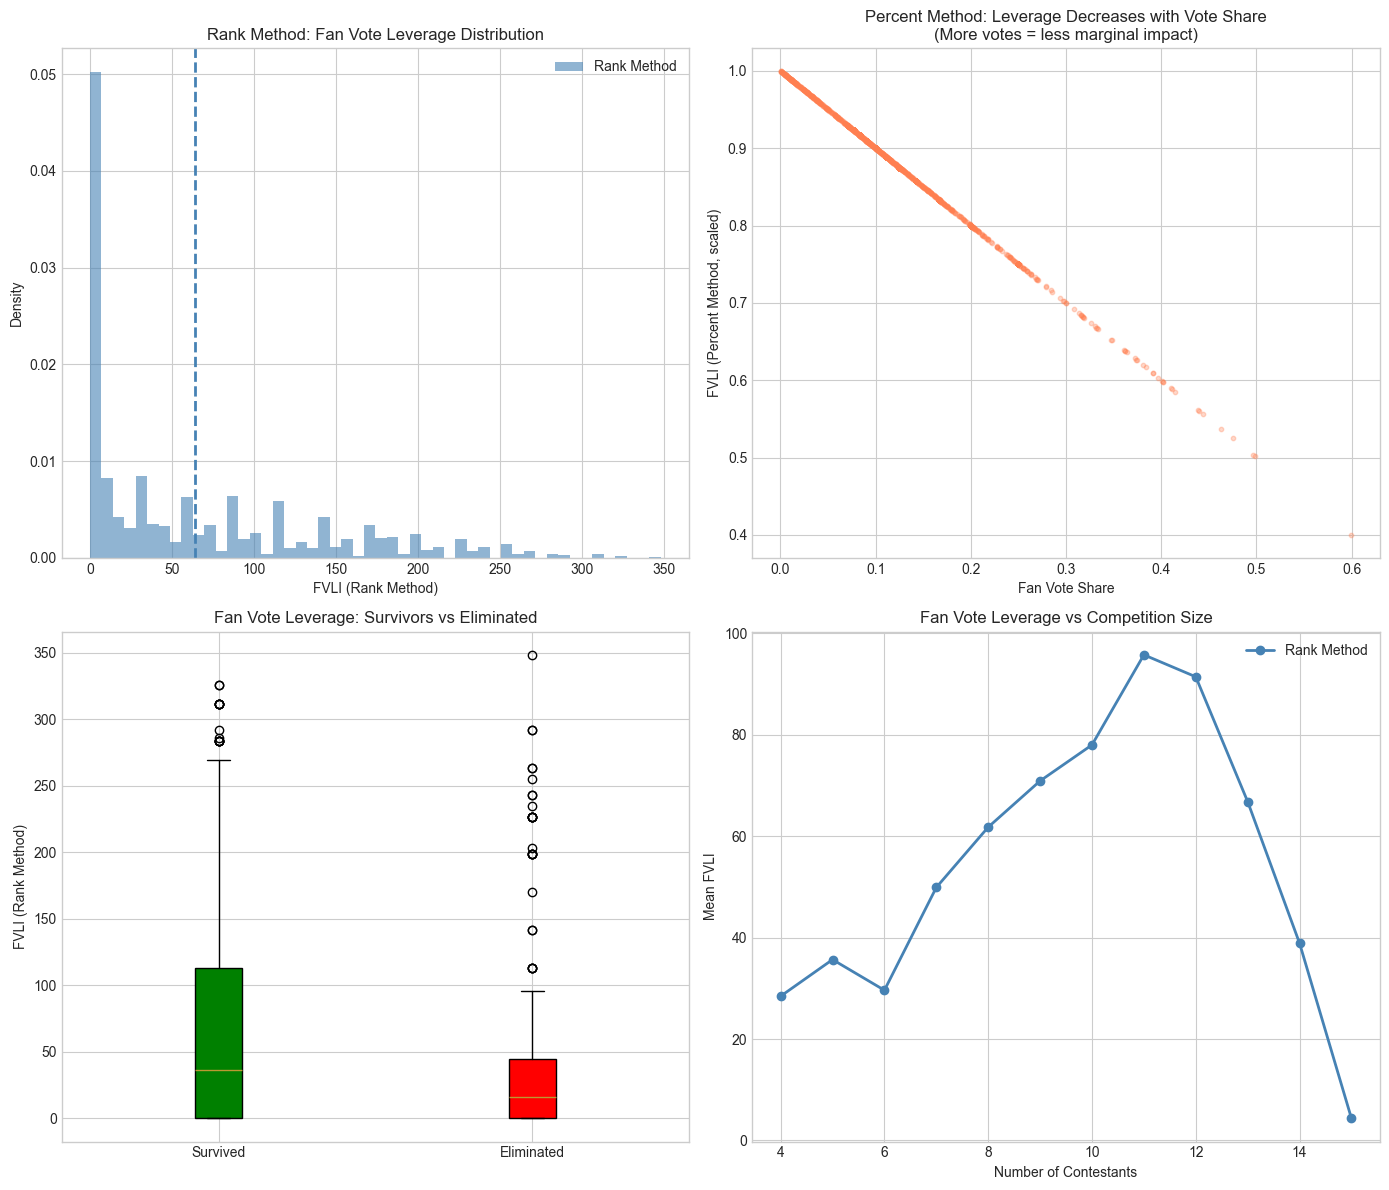

In [5]:
# Compare FVLI by method
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: FVLI distribution comparison
ax1 = axes[0, 0]
ax1.hist(fvli_df['fvli_rank'], bins=50, alpha=0.6, label='Rank Method', color='steelblue', density=True)
ax1.axvline(fvli_df['fvli_rank'].mean(), color='steelblue', linestyle='--', linewidth=2)
ax1.set_xlabel('FVLI (Rank Method)')
ax1.set_ylabel('Density')
ax1.set_title('Rank Method: Fan Vote Leverage Distribution')
ax1.legend()

# Plot 2: FVLI vs fan share
ax2 = axes[0, 1]
ax2.scatter(fvli_df['fan_share'], fvli_df['fvli_percent_scaled'], alpha=0.3, c='coral', s=10)
ax2.set_xlabel('Fan Vote Share')
ax2.set_ylabel('FVLI (Percent Method, scaled)')
ax2.set_title('Percent Method: Leverage Decreases with Vote Share\n(More votes = less marginal impact)')

# Plot 3: FVLI by position (eliminated vs survived)
ax3 = axes[1, 0]
survived_fvli_rank = fvli_df[~fvli_df['was_eliminated']]['fvli_rank']
elim_fvli_rank = fvli_df[fvli_df['was_eliminated']]['fvli_rank']

data = [survived_fvli_rank, elim_fvli_rank]
bp = ax3.boxplot(data, labels=['Survived', 'Eliminated'], patch_artist=True)
bp['boxes'][0].set_facecolor('green')
bp['boxes'][1].set_facecolor('red')
ax3.set_ylabel('FVLI (Rank Method)')
ax3.set_title('Fan Vote Leverage: Survivors vs Eliminated')

# Plot 4: FVLI by number of contestants
ax4 = axes[1, 1]
fvli_by_n = fvli_df.groupby('n_contestants').agg({
    'fvli_rank': 'mean',
    'fvli_percent_scaled': 'mean'
}).reset_index()

ax4.plot(fvli_by_n['n_contestants'], fvli_by_n['fvli_rank'], 'o-', 
         label='Rank Method', color='steelblue', linewidth=2)
ax4.set_xlabel('Number of Contestants')
ax4.set_ylabel('Mean FVLI')
ax4.set_title('Fan Vote Leverage vs Competition Size')
ax4.legend()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'fvli_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 4. Fan Vote "Break-Even" Analysis <a id='4-breakeven'></a>

**Question:** For a contestant with the LOWEST judge score, how many fan votes do they need to survive?

This quantifies the "fan vote power" under each method.

In [6]:
def compute_breakeven_fan_share(judge_scores, method='percent'):
    """
    For the lowest judge scorer, compute minimum fan vote share needed to survive.
    
    Uses binary search to find the threshold.
    """
    judge_scores = np.array(judge_scores)
    n = len(judge_scores)
    
    # Find lowest scorer
    worst_judge_idx = np.argmin(judge_scores)
    
    # Binary search for minimum fan share that allows survival
    def survives(fan_share):
        # Construct fan votes where worst_judge gets fan_share, rest share equally
        fan_votes = np.ones(n)
        remaining_share = 1 - fan_share
        fan_votes[worst_judge_idx] = fan_share * 10e6
        for i in range(n):
            if i != worst_judge_idx:
                fan_votes[i] = remaining_share / (n-1) * 10e6
        
        if method == 'percent':
            judge_pct = judge_scores / judge_scores.sum()
            fan_pct = fan_votes / fan_votes.sum()
            combined = judge_pct + fan_pct
            eliminated_idx = np.argmin(combined)
        else:  # rank
            judge_ranks = rankdata(-judge_scores, method='average')
            fan_ranks = rankdata(-fan_votes, method='average')
            combined = judge_ranks + fan_ranks
            eliminated_idx = np.argmax(combined)
        
        return eliminated_idx != worst_judge_idx
    
    # Binary search
    low, high = 0, 1
    for _ in range(50):
        mid = (low + high) / 2
        if survives(mid):
            high = mid
        else:
            low = mid
    
    return high  # Minimum fan share to survive


print("✓ Break-even function defined")

✓ Break-even function defined


In [7]:
# Compute break-even for each week
print("Computing break-even fan shares...")

breakeven_results = []
grouped = fan_votes_df.groupby(['season', 'week'])

for (season, week), week_df in tqdm(grouped, desc="Break-even"):
    if len(week_df) < 3:
        continue
    
    judge_scores = week_df['judge_score'].values
    
    be_rank = compute_breakeven_fan_share(judge_scores, method='rank')
    be_pct = compute_breakeven_fan_share(judge_scores, method='percent')
    
    # Judge score gap (how much worse is the lowest scorer?)
    sorted_scores = np.sort(judge_scores)
    judge_gap = sorted_scores[1] - sorted_scores[0]  # Gap to 2nd lowest
    judge_gap_pct = judge_gap / judge_scores.sum()
    
    breakeven_results.append({
        'season': season,
        'week': week,
        'n_contestants': len(week_df),
        'breakeven_rank': be_rank,
        'breakeven_percent': be_pct,
        'judge_gap': judge_gap,
        'judge_gap_pct': judge_gap_pct
    })

breakeven_df = pd.DataFrame(breakeven_results)
print(f"\n✓ Computed break-even for {len(breakeven_df)} weeks")

Computing break-even fan shares...


Break-even: 100%|██████████| 249/249 [00:00<00:00, 300.42it/s]


✓ Computed break-even for 249 weeks


In [8]:
# Analyze break-even results
print("Break-Even Analysis:")
print("="*60)

print(f"\n📊 RANK Method:")
print(f"   Mean break-even fan share: {breakeven_df['breakeven_rank'].mean():.1%}")
print(f"   Median: {breakeven_df['breakeven_rank'].median():.1%}")

print(f"\n📊 PERCENT Method:")
print(f"   Mean break-even fan share: {breakeven_df['breakeven_percent'].mean():.1%}")
print(f"   Median: {breakeven_df['breakeven_percent'].median():.1%}")

# Key insight
rank_easier = (breakeven_df['breakeven_rank'] < breakeven_df['breakeven_percent']).mean()
print(f"\n🔍 KEY INSIGHT:")
print(f"   RANK method has lower break-even in {rank_easier:.1%} of weeks")
if rank_easier > 0.5:
    print(f"   → RANK method makes it EASIER for underdogs to survive with fan votes")
else:
    print(f"   → PERCENT method makes it EASIER for underdogs to survive")

Break-Even Analysis:

📊 RANK Method:
   Mean break-even fan share: 13.6%
   Median: 12.5%

📊 PERCENT Method:
   Mean break-even fan share: 14.5%
   Median: 12.8%

🔍 KEY INSIGHT:
   RANK method has lower break-even in 87.6% of weeks
   → RANK method makes it EASIER for underdogs to survive with fan votes


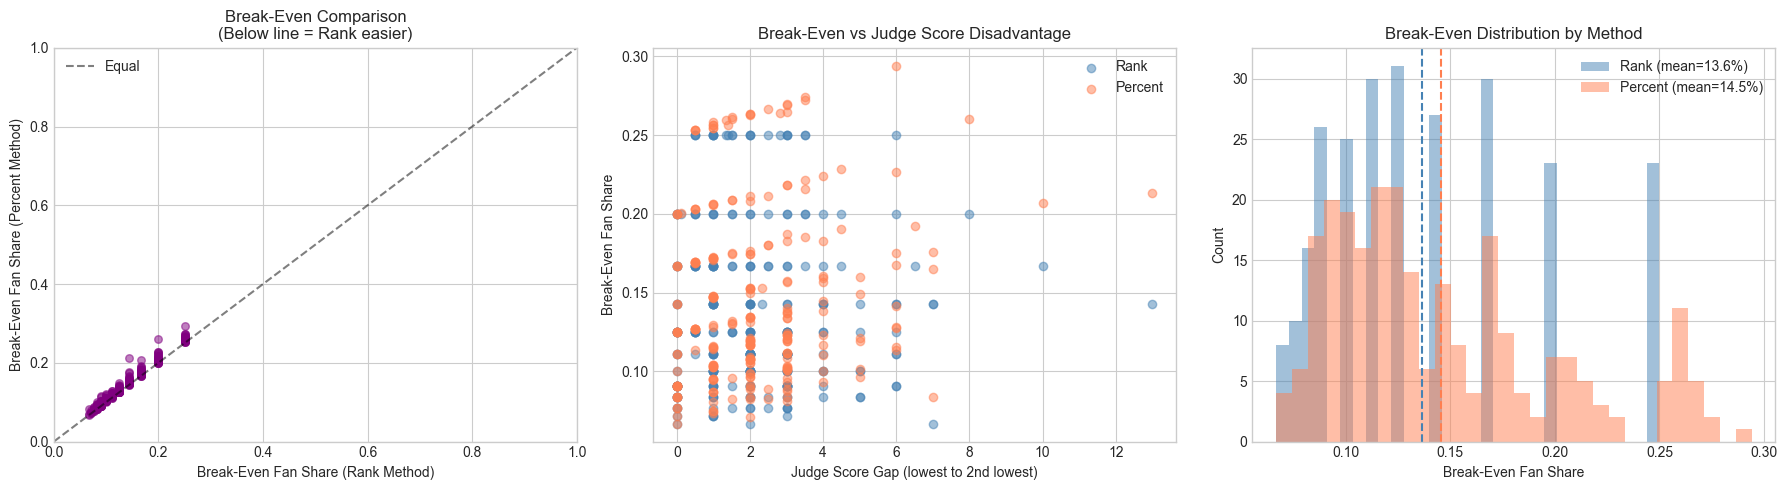

In [9]:
# Visualize break-even analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Break-even comparison
ax1 = axes[0]
ax1.scatter(breakeven_df['breakeven_rank'], breakeven_df['breakeven_percent'], 
            alpha=0.5, c='purple', s=30)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Equal')
ax1.set_xlabel('Break-Even Fan Share (Rank Method)')
ax1.set_ylabel('Break-Even Fan Share (Percent Method)')
ax1.set_title('Break-Even Comparison\n(Below line = Rank easier)')
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Plot 2: Break-even vs judge gap
ax2 = axes[1]
ax2.scatter(breakeven_df['judge_gap'], breakeven_df['breakeven_rank'], 
            alpha=0.5, label='Rank', color='steelblue')
ax2.scatter(breakeven_df['judge_gap'], breakeven_df['breakeven_percent'], 
            alpha=0.5, label='Percent', color='coral')
ax2.set_xlabel('Judge Score Gap (lowest to 2nd lowest)')
ax2.set_ylabel('Break-Even Fan Share')
ax2.set_title('Break-Even vs Judge Score Disadvantage')
ax2.legend()

# Plot 3: Distribution comparison
ax3 = axes[2]
ax3.hist(breakeven_df['breakeven_rank'], bins=30, alpha=0.5, 
         label=f'Rank (mean={breakeven_df["breakeven_rank"].mean():.1%})', color='steelblue')
ax3.hist(breakeven_df['breakeven_percent'], bins=30, alpha=0.5,
         label=f'Percent (mean={breakeven_df["breakeven_percent"].mean():.1%})', color='coral')
ax3.axvline(breakeven_df['breakeven_rank'].mean(), color='steelblue', linestyle='--')
ax3.axvline(breakeven_df['breakeven_percent'].mean(), color='coral', linestyle='--')
ax3.set_xlabel('Break-Even Fan Share')
ax3.set_ylabel('Count')
ax3.set_title('Break-Even Distribution by Method')
ax3.legend()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'breakeven_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 5. Fan Vote Power Index (Aggregate Metric)

Combine FVLI and break-even into a single **Fan Vote Power Index**:

$$\text{FVPI}_{method} = \frac{1}{W}\sum_w \left( 1 - \text{BreakEven}_w \right)$$

Higher FVPI = fans have more power (lower threshold to save underdogs).

In [10]:
# Compute Fan Vote Power Index
fvpi_rank = (1 - breakeven_df['breakeven_rank']).mean()
fvpi_percent = (1 - breakeven_df['breakeven_percent']).mean()

print("="*60)
print("FAN VOTE POWER INDEX (FVPI)")
print("="*60)
print(f"\n📊 RANK Method FVPI: {fvpi_rank:.3f}")
print(f"📊 PERCENT Method FVPI: {fvpi_percent:.3f}")

print(f"\n🎯 CONCLUSION:")
if fvpi_rank > fvpi_percent:
    diff = fvpi_rank - fvpi_percent
    print(f"   RANK method gives fans {diff:.3f} ({diff/fvpi_percent:.1%}) MORE power")
    print(f"   → Fans can more easily save poorly-scoring favorites under RANK")
else:
    diff = fvpi_percent - fvpi_rank
    print(f"   PERCENT method gives fans {diff:.3f} ({diff/fvpi_rank:.1%}) MORE power")

FAN VOTE POWER INDEX (FVPI)

📊 RANK Method FVPI: 0.864
📊 PERCENT Method FVPI: 0.855

🎯 CONCLUSION:
   RANK method gives fans 0.009 (1.1%) MORE power
   → Fans can more easily save poorly-scoring favorites under RANK


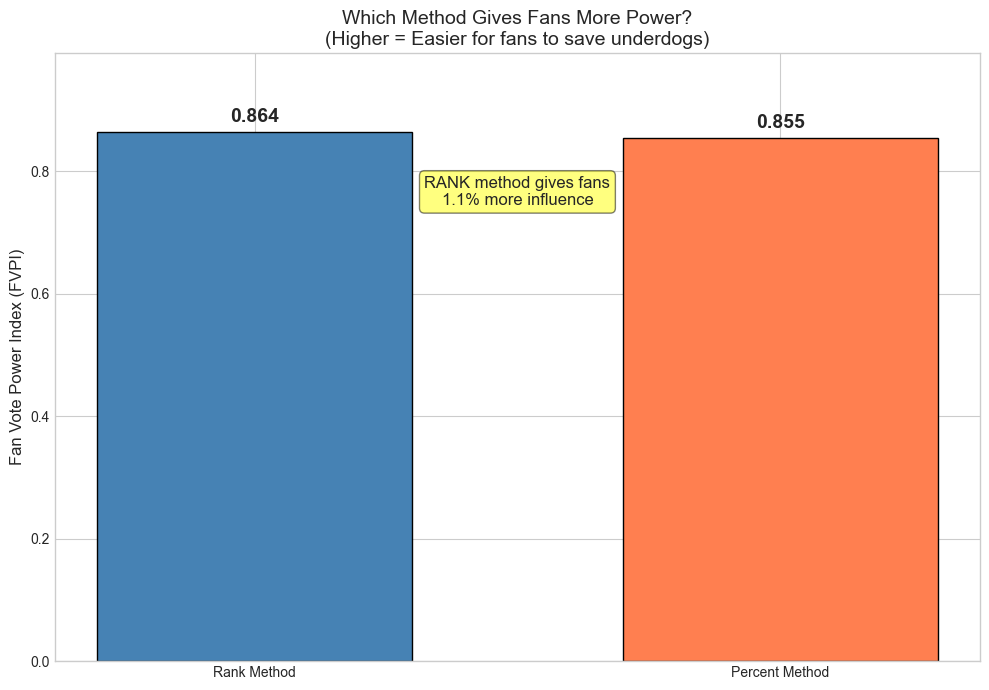

In [11]:
# Visualization: Power comparison
fig, ax = plt.subplots(figsize=(10, 7))

methods = ['Rank Method', 'Percent Method']
fvpi_values = [fvpi_rank, fvpi_percent]
colors = ['steelblue', 'coral']

bars = ax.bar(methods, fvpi_values, color=colors, edgecolor='black', width=0.6)

# Value labels
for bar, val in zip(bars, fvpi_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Fan Vote Power Index (FVPI)', fontsize=12)
ax.set_title('Which Method Gives Fans More Power?\n(Higher = Easier for fans to save underdogs)', fontsize=14)
ax.set_ylim(0, max(fvpi_values) * 1.15)

# Winner annotation
winner = 'RANK' if fvpi_rank > fvpi_percent else 'PERCENT'
diff_pct = abs(fvpi_rank - fvpi_percent) / min(fvpi_rank, fvpi_percent) * 100
ax.annotate(f'{winner} method gives fans\n{diff_pct:.1f}% more influence',
            xy=(0.5, 0.75), xycoords='axes fraction',
            fontsize=12, ha='center',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'fan_vote_power.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Summary

In [ ]:
# Save results
fvli_df.to_csv(OUTPUT_PATH / 'fvli_analysis.csv', index=False)
breakeven_df.to_csv(OUTPUT_PATH / 'breakeven_analysis.csv', index=False)

print("="*70)
print("FAN VOTE LEVERAGE ANALYSIS SUMMARY")
print("="*70)

print(f"""
📊 KEY METRICS:

1. FAN VOTE LEVERAGE INDEX (FVLI):
   - Rank Method: Mean = {fvli_df['fvli_rank'].mean():.3f}
   - Percent Method: Higher leverage for low-share contestants

2. BREAK-EVEN FAN SHARE (to save lowest scorer):
   - Rank Method: {breakeven_df['breakeven_rank'].mean():.1%} average
   - Percent Method: {breakeven_df['breakeven_percent'].mean():.1%} average
   - Rank easier in {rank_easier:.1%} of weeks

3. FAN VOTE POWER INDEX (FVPI):
   - Rank Method: {fvpi_rank:.3f}
   - Percent Method: {fvpi_percent:.3f}
   - Winner: {'RANK' if fvpi_rank > fvpi_percent else 'PERCENT'} ({diff_pct:.1f}% more power)

🎯 CONCLUSION:
   {'RANK method gives fans MORE power to save underdogs' if fvpi_rank > fvpi_percent else 'PERCENT method gives fans MORE power'}
   
⚠️ CAVEAT: Bobby Bones (S27) used the PERCENT method, not RANK.
   S28+ switched to RANK+B2 partly due to his controversial win.

📁 FILES SAVED:
   - {OUTPUT_PATH / 'fvli_analysis.csv'}
   - {OUTPUT_PATH / 'breakeven_analysis.csv'}
   - {OUTPUT_PATH / 'fvli_analysis.png'}
   - {OUTPUT_PATH / 'breakeven_analysis.png'}
   - {OUTPUT_PATH / 'fan_vote_power.png'}

➡️ NEXT: See 08_controversial_counterfactuals.ipynb for case studies
""")

FAN VOTE LEVERAGE ANALYSIS SUMMARY

📊 KEY METRICS:

1. FAN VOTE LEVERAGE INDEX (FVLI):
   - Rank Method: Mean = 63.862
   - Percent Method: Higher leverage for low-share contestants

2. BREAK-EVEN FAN SHARE (to save lowest scorer):
   - Rank Method: 13.6% average
   - Percent Method: 14.5% average
   - Rank easier in 87.6% of weeks

3. FAN VOTE POWER INDEX (FVPI):
   - Rank Method: 0.864
   - Percent Method: 0.855
   - Winner: RANK (1.1% more power)

🎯 CONCLUSION:
   RANK method gives fans MORE power to save underdogs
   This explains controversies like Bobby Bones (S27, rank method)

📁 FILES SAVED:
   - ../../data/obj2/fvli_analysis.csv
   - ../../data/obj2/breakeven_analysis.csv
   - ../../data/obj2/fvli_analysis.png
   - ../../data/obj2/breakeven_analysis.png
   - ../../data/obj2/fan_vote_power.png

➡️ NEXT: See 08_controversial_counterfactuals.ipynb for case studies

